In [20]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import accuracy_score, make_scorer, balanced_accuracy_score
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import MinMaxScaler

import mlrose



-1    4849
 1    1001
Name: cleave, dtype: int64

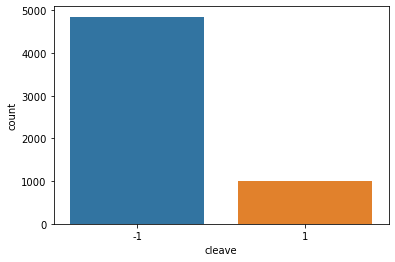

In [25]:
# Dataset source:
#http://archive.ics.uci.edu/ml/datasets/HIV-1+protease+cleavage#
# combined all datasets, removing duplicates

# Read in data
data = pd.read_csv('../data/HIV_DataSet.csv', sep=',')

sns.countplot(data['cleave']) # plot number of things with each value
# number of negative cleave values versus positive.
data['cleave'].value_counts(sort=True)

In [4]:
# 'Frozen' NNet for Assignment 1
clf = MLPClassifier(activation='relu', alpha=0.01, batch_size='auto', beta_1=0.9,
              beta_2=0.999, early_stopping=True, epsilon=1e-08,
              hidden_layer_sizes=5, learning_rate='constant',
              learning_rate_init=0.001, max_fun=15000, max_iter=300,
              momentum=0.9, n_iter_no_change=40, nesterovs_momentum=True,
              power_t=0.5, random_state=0, shuffle=True, solver='adam',
              tol=0.0001, validation_fraction=0.1, verbose=False,
              warm_start=False)

In [ ]:
# Tuning 

x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, test_size=0.2) # 80/20 default

# scale so it converges
scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
x_train = scaling.transform(x_train)
x_test = scaling.transform(x_test)


algos=[]'random_hill_climb', 'simulated_annealing', 'genetic_alg']

clf = mlrose.NeuralNetwork(
    hidden_nodes = [5], activation = 'relu', early_stopping=True, 
    random_state=0, is_classifier=True, bias=True)

parameters = {'algorithm': algos,
              'max_iters': 100 * np.arange(1, 3),
              'restarts': [1, 2, 3, 4, 5, 6],
              'max_attempts', 10 * np.arrange(1, 5)
              'learning_rate': [.0001, .001, .1]
             }

# Type of scoring used to compare parameter combinations
acc_scorer = make_scorer(accuracy_score)

# Run the grid search
grid_obj = GridSearchCV(clf, parameters, scoring=acc_scorer, cv=5, n_jobs=4)
grid_obj = grid_obj.fit(x_train, y_train)

# Set the clf to the best combination of parameters
clf = grid_obj.best_estimator_

# Fit the best algorithm to the data. 
clf.fit(x_train, y_train)

In [34]:
# Cross val example https://piazza.com/class/k51r1vdohil5g3?cid=464

# Create training, testing, and validation sets

X = data.drop('cleave', axis=1) # last value is the cleavage
y = data['cleave']

# Initialize neural network object and fit object
# Loosely based on https://towardsdatascience.com/fitting-a-neural-network-using-randomized-optimization-in-python-71595de4ad2d

algos=[]'random_hill_climb', 'simulated_annealing', 'genetic_alg']
train_sizes = [.3, .4, .5, .6, .7, .8, .9]
results={'algo': [], 'train_size': [], 'train_acc': [], 'test_acc': [], 'cv_acc': []}

for algo in algos:
    for s in train_sizes:
        x_train, x_test, y_train, y_test = train_test_split(X, y, random_state=0, train_size=s) # 80/20 default

        # scale so it converges
        scaling = MinMaxScaler(feature_range=(-1,1)).fit(x_train)
        x_train = scaling.transform(x_train)
        x_test = scaling.transform(x_test)
        print(algo)
        results['algo'].append(algo)
        results['train_size'].append(s)
        nn = mlrose.NeuralNetwork(hidden_nodes = [5], activation = 'relu',
                                         algorithm = algo, max_iters=300, restarts=5,
                                         bias=True, is_classifier=True, learning_rate=0.0001,
                                         early_stopping=True, clip_max=5, max_attempts=40,
                                  random_state=0)

        nn.fit(x_train, y_train)

        # Predict labels for train set and assess accuracy
        y_train_pred = nn.predict(x_train)

        y_train_accuracy = accuracy_score(y_train, y_train_pred)
        results['train_acc'].append(y_train_accuracy)
        #print(algo)
        #print('Training accuracy: ', y_train_accuracy)

        # Predict labels for test set and assess accuracy
        y_test_pred = nn.predict(x_test)

        y_test_accuracy = accuracy_score(y_test, y_test_pred)
        results['test_acc'].append(y_test_accuracy)

        #print('Test accuracy: ', y_test_accuracy)

        cv_results = cross_validate(nn, x_train, y_train, cv=5)
        results['cv_acc'].append(cv_results)
        #print(cv_results)
        
results = pd.DataFrame(results)

results.to_csv('results.csv')

random_hill_climb
random_hill_climb
random_hill_climb
random_hill_climb
random_hill_climb
random_hill_climb
random_hill_climb
genetic_alg
genetic_alg
genetic_alg
genetic_alg
genetic_alg
genetic_alg
genetic_alg
simulated_annealing
simulated_annealing
simulated_annealing
simulated_annealing
simulated_annealing
simulated_annealing
simulated_annealing
